## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

Padded BG data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [3]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [4]:
data_dir = Path('data_02')
data_orig = Path('data')

In [5]:
RETRAIN = True
RESIZE_IMAGES = True

In [6]:
MODEL_NAME='cv_reflect_101_valid'

In [7]:
NB_NUM='03_22'

In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: ea147ee7, DATE: 20191118


In [9]:
DATE = '20191118'
UID = '6b964068'

In [10]:
SUB_NUM='20'

In [11]:
#wrap or reflect
border='reflect'
#padded or padded_bg
pad_type='padded'
img_size=256

In [12]:
train_images=data_dir/f'train/rotated/clipped/{pad_type}/{border}/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{pad_type}/{border}/{img_size}'

In [13]:
test_names = get_image_files(test_images)

In [14]:
assert len(test_names)==7325

In [15]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [16]:
len(df_all)

22553

In [17]:
df_valid=df_all.loc[df_all['verified'] == True]

In [18]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [19]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [20]:
assert len(df_test)==7325

In [21]:
df_valid.loc[df_valid['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [22]:
len(df_valid)

14870

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [23]:
xtra_tfms=[dihedral(p=0.7), rand_crop(p=0.4)]
tfms = get_transforms(flip_vert=True, max_lighting=0.2, max_zoom=1.1, max_warp=0., xtra_tfms=xtra_tfms)
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [24]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [25]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [26]:
#to check what params object has
#dir(data)

In [27]:
data.label_list

LabelLists;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data_02/train/rotated/clipped/padded/reflect/256;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,concrete_cement,irregular_metal,irregular_metal,concrete_cement
Path: data_02/train/rotated/clipped/padded/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_02/train/rotated/clipped/padded/reflect/256

In [28]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

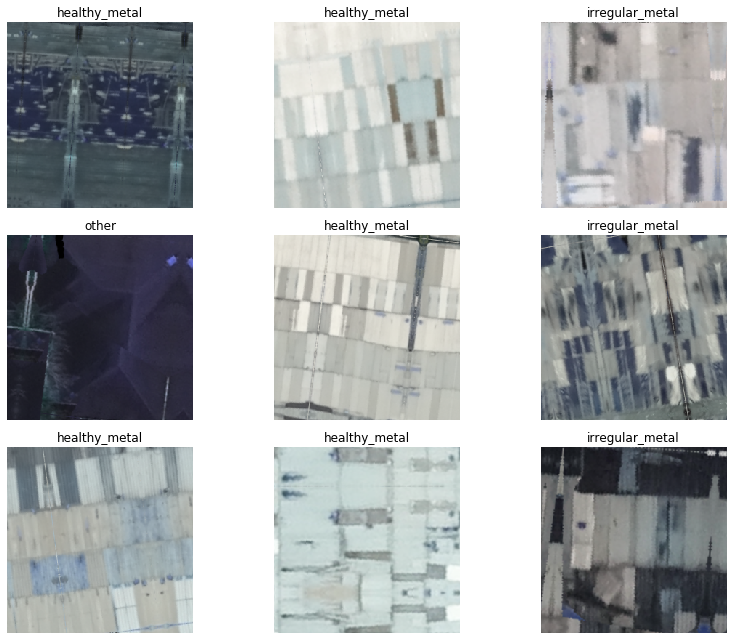

In [29]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [30]:
arch = models.resnet152
arch_name = 'rn152'

In [31]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()

In [32]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


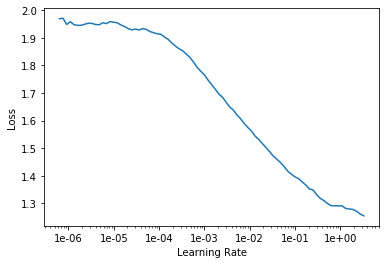

In [34]:
learn.recorder.plot()

Then we can fit the head of our network.

In [35]:
lr = 2e-3

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.071183,0.894351,0.258911,01:41
1,0.798634,0.706343,0.216543,01:37
2,0.649585,0.607177,0.205447,01:35


In [ ]:
print(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')
#saves in parent of models directory
#learn.export()

In [ ]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
learn.fit_one_cycle(3, slice(lr))

In [ ]:
learn.save(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [ ]:
learn.load(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

In [ ]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(2e-6, lr/5))

<pre>
basic transforms
 epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.498293 	0.524446 	0.191661 	02:07
1 	0.480821 	0.512048 	0.181237 	02:03
2 	0.427257 	0.506570 	0.173840 	02:03
3 	0.404179 	0.508073 	0.184264 	02:02
4 	0.355685 	0.512222 	0.181237 	01:48
    </pre>

In [ ]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
#learn.fit_one_cycle(5, slice(2e-6, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
#learn.save(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
#learn.load(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
#learn=learn.to_fp32()

In [ ]:
#learn.export()

### Larger size images

In [ ]:
train_images=data_dir/f'train/rotated/clipped/{pad_type}/{border}/512'
test_images=data_dir/f'test/rotated/clipped/{pad_type}/{border}/512'

In [ ]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [ ]:
data = (src.transform(tfms, size=512)
        .databunch(bs=bs/2).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

In [ ]:
learn=learn.to_fp16()

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=5e-5

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save(f'stage-1-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save(f'stage-2-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
learn.load(f'stage-2-512-{arch_name}-{MODEL_NAME}-{DATE}-{UID}')

In [ ]:
learn=learn.to_fp32()

In [ ]:
learn.export()

### inference

In [ ]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [ ]:
len(test_dataset)

In [ ]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{pad_type}/{border}/{img_size}', test=test_dataset)

In [ ]:
learn.data.loss_func

In [ ]:
type(learn.data)

In [ ]:
type(learn.dl(DatasetType.Test))

In [ ]:
len(learn.dl(DatasetType.Test))

Get number of items in the Valid dataset (in DeviceDataLoader)

In [ ]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
labels = np.argmax(preds, 1)

In [ ]:
len(preds)

In [ ]:
preds[0].tolist()

In [ ]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [ ]:
len(labels)

In [ ]:
learn.data.classes

In [ ]:
data.classes

In [ ]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [ ]:
test_predictions[0]

In [ ]:
type(learn.data.test_ds)

In [ ]:
 learn.data.test_ds.x.items

In [ ]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [ ]:
preds_list[0]

In [ ]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [ ]:
cols

In [ ]:
df.head()

In [ ]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [ ]:
pred_df.insert(loc=0, column='id', value=ids)

In [ ]:
pred_df.columns = cols

In [ ]:
pred_df.head()

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [ ]:
pred_ids=pred_df['id'].values.tolist()

In [ ]:
df_baseline = pd.read_csv(data_orig/f'submissions/mean_baseline.csv')

In [ ]:
df_baseline.head()

In [ ]:
baseline_ids=df_baseline['id'].values.tolist()

In [ ]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [ ]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [ ]:
pred_df.head()

In [ ]:
pred_df=pred_df.sort_values('id_cat')

In [ ]:
pred_df.head()

In [ ]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [ ]:
pred_df.to_csv(data_orig/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [ ]:
### Submission 2: 0.4687


In [ ]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

In [ ]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")